# COPY - Lumo Run - Deep Fully Connected Neural Network

#### This copy of the original document has minor modifications to ensure compatibility (i.e. after folder changes)

#### Load dependencies

In [1]:
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout 
from keras.layers.normalization import BatchNormalization 
from keras import regularizers 
from keras.optimizers import SGD

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
import tensorflow as tf
from datetime import datetime
from dateutil import tz
from IPython import embed
import time
import socket

from pathlib import Path
from sklearn.metrics import confusion_matrix 

np.random.seed(7) # Set seed for reproducibility

C:\Users\adam\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


#### Set Hyperparameters

In [2]:
# Data Setup
num_channels = 7 # number of channels of data (i.e. 7 kinematic and 4 anthropometric)
num_anthropometrics = 4
input_num_timestamps = 11 # number of timestamps used in the input for prediction
label_window_size = 5 # number of timestamps used to label the speed we will be predicting
speed_bucket_size = '0.1' # how to round the data for classification. Consider '0.5', '0.1', and 'none_use_regression'
myFileLocation = 'C:/Users/adam/Documents/CS 230/Project/Lumo Data/TimeSeries_InputVector_100runs.csv' # CHANGED
        # Other data files to use:
        # '../datasets/SAMPLE_TimeSeries_Longest1000Runs_wAnthro_MultiLabeledSpeed_20180523.csv'
        # '../datasets/quarter-big.csv'
        # '../datasets/TimeSeries_InputVector_15runs.csv'
        # 'C:/Users/adam/Documents/CS 230/Project/TimeSeries_InputVector_100runs.csv'

# Architecture
num_layers = 6 # for documentation purposes
num_hidden_units_L1 = 256
num_hidden_units_L2 = 256
num_hidden_units_L3 = 256
num_hidden_units_L4 = 128
num_hidden_units_L5 = 128
num_hidden_units_L6 = 128

activations_strategy = 'r-r-r-r-r-r' # for documentation purposes
activation_L1 = 'relu'
activation_L2 = 'relu'
activation_L3 = 'relu'
activation_L4 = 'relu'
activation_L5 = 'relu'
activation_L6 = 'relu'

dropout_rates = '1-1-1-.8-.8-.8' # documentation
dropout_rate_L1 = 1.0 
dropout_rate_L2 = 1.0
dropout_rate_L3 = 1.0
dropout_rate_L4 = 0.8
dropout_rate_L5 = 0.8
dropout_rate_L6 = 0.8

# Training strategy
batch_size = 128
learning_rate = 0.0001
training_epochs = 5 # CHANGED
loss_function = 'categorical_crossentropy' # 'categorical_crossentropy' ,'mse', 'mae', 'class_mse', 'class_mae'

#### Set Up Automatic Reporting and Plotting

In [3]:
#Ploting and Reporting
accuracy_reporting_metric_1 = 'class_mae' # 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
dev_reporting_metric_1 = 'val_'+accuracy_reporting_metric_1
accuracy_reporting_metric_2 = 'class_percent_2buckRange' # 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
dev_reporting_metric_2 = 'val_'+accuracy_reporting_metric_2
accuracy_reporting_metric_3 = 'class_mse' # 'acc', 'class_percent_1buckRange', 'class_percent_2buckRange'
dev_reporting_metric_3 = 'val_'+accuracy_reporting_metric_3

plt.style.use('ggplot')

In [4]:
# How to store file once model finishes

name = input("String to add to model filename, defaults to time stamp if nothing entered.")  
if name == "":
    name = time.time() #user input for filename of saved model, defaults to timestamp
plot_note=input("Note you'd like to add to plot:") #user input to add note to plot
model_to_load=input("enter the model name to load - leave blank to start fresh") #user input to load prev model
results_file_name=input("name of results file") # name of results file

String to add to model filename, defaults to time stamp if nothing entered.
Note you'd like to add to plot:
enter the model name to load - leave blank to start fresh
name of results file


#### Define functions for data processing and plotting

In [5]:
def read_data(file_path):
    data = pd.read_csv(file_path,header = 0) #This uses the header row (row 0) as the column names
    return data

def feature_normalize(dataset):
    mu = np.mean(dataset,axis = 0)
    sigma = np.std(dataset,axis = 0)
    return (dataset - mu)/sigma

def windows(data, size):
    start = 0
    while start < data.count():
        yield int(start), int(start + size)
        start += 1 #(size / 2)

# Used for vectorized input WITH SQL pre-processing
def segment_signal_vector(data):
    dataframe_input = data.loc[:, 'gender':'pelvic_tilt_lag_0'] # select all columns from gender to pelvic_tilt_lag_0
    dataframe_labels = data.loc[:, 'gps_speed_lag_7':'gps_speed_lag_3'] # select all columns from gender to pelvic_tilt_lag_0
    segments = dataframe_input.values
    labels_before_avg = dataframe_labels.values
    if speed_bucket_size == '0.1':
        labels = np.around(np.mean(labels_before_avg, axis=1),decimals=1)
    elif speed_bucket_size == '0.5':
        labels = np.around(2*np.mean(labels_before_avg, axis=1),decimals=0)/2
    elif speed_bucket_size == 'none_use_regression':
        labels = np.mean(labels_before_avg, axis=1)
    return segments, labels

# Used for vectorized input WITHOUT SQL pre-processing
def segment_signal(data,input_num_timestamps = input_num_timestamps):
    segments = np.empty((0,input_num_timestamps*num_channels + num_anthropometrics))
    labels = np.empty((0))
    for (start, end) in windows(data['timestamp'], input_num_timestamps):
        aa = data["age"][start]
        bb = data["weight"][start]
        cc = data["height"][start]
        dd = data["gender"][start] 
        a = data["bounce"][start:end]
        b = data["braking"][start:end]
        c = data["cadence"][start:end]
        d = data["ground_contact"][start:end]
        e = data["pelvic_drop"][start:end]
        f = data["pelvic_rotation"][start:end]
        g = data["pelvic_tilt"][start:end]
        if(end < data.shape[0] and
           len(data['timestamp'][start:end]) == input_num_timestamps and data['activity_id'][start]==data['activity_id'][end]):
            segments_toadd = np.vstack([np.dstack([a,b,c,d,e,f,g])])
            segments_toadd_reshape = segments_toadd.reshape(input_num_timestamps * num_channels)
            segments = np.vstack([segments,np.hstack([aa,bb,cc,dd,segments_toadd_reshape])])
            start_labeling = np.int(np.floor(start+(end-start)/2) - np.floor(label_window_size/2))
            end_labeling = start_labeling + label_window_size
            if speed_bucket_size == '0.1':
                labels = np.append(labels,np.around(np.mean(data["gps_speed_true"][start_labeling:end_labeling]),decimals=1)) # round to nearest decimal
            elif speed_bucket_size == '0.5':
                labels = np.append(labels,np.around(2*np.mean(data["gps_speed_true"][start_labeling:end_labeling]),decimals=0)/2) # round to nearest half unit
            elif speed_bucket_size == 'none_use_regression':
                labels = np.append(labels,np.mean(data["gps_speed_true"][start_labeling:end_labeling])) # no rounding, use regression
    return segments, labels

def load_results_file(results_file_name):
    my_file = Path("../results/"+results_file_name+".csv")
    if my_file.is_file():
        print("Found results file")
        prev_results=pd.read_csv(my_file,header=0)
        print(list(prev_results.columns.values))
        return prev_results
    else:
        print("no results file found - creating file")
        a=[["FCN",
            name,
            "na",
            myFileLocation,
            training_epochs,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            0.0,
            batch_size,
            num_layers,
            activations_strategy,
            dropout_rates,
            learning_rate,
            speed_bucket_size,
            loss_function,
            input_num_timestamps,
            label_window_size,
            "",
            "",
            ""
            ]]
        
        df=pd.DataFrame(a, columns=["model type",
                                    "model filename",
                                    "plot filename",
                                    "data filename",
                                    "epochs",
                                    "runtime",
                                    "dev accuracy 1",
                                    "train accuracy 1",
                                    "dev accuracy 2",
                                    "train accuracy 2",
                                    "dev accuracy 3",
                                    "train accuracy 4",
                                    "batch_size",
                                    "num_layers",
                                    "activations_strategy",
                                    "dropout_rates",
                                    "learning_rate",
                                    "speed_bucket_size",
                                    "loss_function",
                                    "input_num_timestamps",
                                    "label_window_size",
                                    "evaluation_metric_1",
                                    "evaluation_metric_2",
                                    "evaluation_metric_3",])
        
        df.to_csv("../results/"+results_file_name+".csv",index=False ) 
        return df

#### Normalize Data

In [6]:
dataset = read_data(myFileLocation)

# For input without SQL pre-processing
# dataset['bounce'] = feature_normalize(dataset['bounce'])
# dataset['braking'] = feature_normalize(dataset['braking'])
# dataset['cadence'] = feature_normalize(dataset['cadence'])
# dataset['ground_contact'] = feature_normalize(dataset['ground_contact'])
# dataset['pelvic_drop'] = feature_normalize(dataset['pelvic_drop'])
# dataset['pelvic_rotation'] = feature_normalize(dataset['pelvic_rotation'])
# dataset['pelvic_tilt'] = feature_normalize(dataset['pelvic_tilt'])
# dataset['age'] = feature_normalize(dataset['age'])
# dataset['weight'] = feature_normalize(dataset['weight'])
# dataset['height'] = feature_normalize(dataset['height'])
# dataset['gender'] = feature_normalize(dataset['gender'])

# For input with SQL pre-processing
dataset['gender'] = feature_normalize(dataset['gender'])
dataset['age'] = feature_normalize(dataset['age'])
dataset['height'] = feature_normalize(dataset['height'])
dataset['weight'] = feature_normalize(dataset['weight'])
dataset['bounce_lag_10'] = feature_normalize(dataset['bounce_lag_10'])
dataset['bounce_lag_9'] = feature_normalize(dataset['bounce_lag_9'])
dataset['bounce_lag_8'] = feature_normalize(dataset['bounce_lag_8'])
dataset['bounce_lag_7'] = feature_normalize(dataset['bounce_lag_7'])
dataset['bounce_lag_6'] = feature_normalize(dataset['bounce_lag_6'])
dataset['bounce_lag_5'] = feature_normalize(dataset['bounce_lag_5'])
dataset['bounce_lag_4'] = feature_normalize(dataset['bounce_lag_4'])
dataset['bounce_lag_3'] = feature_normalize(dataset['bounce_lag_3'])
dataset['bounce_lag_2'] = feature_normalize(dataset['bounce_lag_2'])
dataset['bounce_lag_1'] = feature_normalize(dataset['bounce_lag_1'])
dataset['bounce_lag_0'] = feature_normalize(dataset['bounce_lag_0'])
dataset['braking_lag_10'] = feature_normalize(dataset['braking_lag_10'])
dataset['braking_lag_9'] = feature_normalize(dataset['braking_lag_9'])
dataset['braking_lag_8'] = feature_normalize(dataset['braking_lag_8'])
dataset['braking_lag_7'] = feature_normalize(dataset['braking_lag_7'])
dataset['braking_lag_6'] = feature_normalize(dataset['braking_lag_6'])
dataset['braking_lag_5'] = feature_normalize(dataset['braking_lag_5'])
dataset['braking_lag_4'] = feature_normalize(dataset['braking_lag_4'])
dataset['braking_lag_3'] = feature_normalize(dataset['braking_lag_3'])
dataset['braking_lag_2'] = feature_normalize(dataset['braking_lag_2'])
dataset['braking_lag_1'] = feature_normalize(dataset['braking_lag_1'])
dataset['braking_lag_0'] = feature_normalize(dataset['braking_lag_0'])
dataset['cadence_lag_10'] = feature_normalize(dataset['cadence_lag_10'])
dataset['cadence_lag_9'] = feature_normalize(dataset['cadence_lag_9'])
dataset['cadence_lag_8'] = feature_normalize(dataset['cadence_lag_8'])
dataset['cadence_lag_7'] = feature_normalize(dataset['cadence_lag_7'])
dataset['cadence_lag_6'] = feature_normalize(dataset['cadence_lag_6'])
dataset['cadence_lag_5'] = feature_normalize(dataset['cadence_lag_5'])
dataset['cadence_lag_4'] = feature_normalize(dataset['cadence_lag_4'])
dataset['cadence_lag_3'] = feature_normalize(dataset['cadence_lag_3'])
dataset['cadence_lag_2'] = feature_normalize(dataset['cadence_lag_2'])
dataset['cadence_lag_1'] = feature_normalize(dataset['cadence_lag_1'])
dataset['cadence_lag_0'] = feature_normalize(dataset['cadence_lag_0'])
dataset['ground_contact_lag_10'] = feature_normalize(dataset['ground_contact_lag_10'])
dataset['ground_contact_lag_9'] = feature_normalize(dataset['ground_contact_lag_9'])
dataset['ground_contact_lag_8'] = feature_normalize(dataset['ground_contact_lag_8'])
dataset['ground_contact_lag_7'] = feature_normalize(dataset['ground_contact_lag_7'])
dataset['ground_contact_lag_6'] = feature_normalize(dataset['ground_contact_lag_6'])
dataset['ground_contact_lag_5'] = feature_normalize(dataset['ground_contact_lag_5'])
dataset['ground_contact_lag_4'] = feature_normalize(dataset['ground_contact_lag_4'])
dataset['ground_contact_lag_3'] = feature_normalize(dataset['ground_contact_lag_3'])
dataset['ground_contact_lag_2'] = feature_normalize(dataset['ground_contact_lag_2'])
dataset['ground_contact_lag_1'] = feature_normalize(dataset['ground_contact_lag_1'])
dataset['ground_contact_lag_0'] = feature_normalize(dataset['ground_contact_lag_0'])
dataset['pelvic_drop_lag_10'] = feature_normalize(dataset['pelvic_drop_lag_10'])
dataset['pelvic_drop_lag_9'] = feature_normalize(dataset['pelvic_drop_lag_9'])
dataset['pelvic_drop_lag_8'] = feature_normalize(dataset['pelvic_drop_lag_8'])
dataset['pelvic_drop_lag_7'] = feature_normalize(dataset['pelvic_drop_lag_7'])
dataset['pelvic_drop_lag_6'] = feature_normalize(dataset['pelvic_drop_lag_6'])
dataset['pelvic_drop_lag_5'] = feature_normalize(dataset['pelvic_drop_lag_5'])
dataset['pelvic_drop_lag_4'] = feature_normalize(dataset['pelvic_drop_lag_4'])
dataset['pelvic_drop_lag_3'] = feature_normalize(dataset['pelvic_drop_lag_3'])
dataset['pelvic_drop_lag_2'] = feature_normalize(dataset['pelvic_drop_lag_2'])
dataset['pelvic_drop_lag_1'] = feature_normalize(dataset['pelvic_drop_lag_1'])
dataset['pelvic_drop_lag_0'] = feature_normalize(dataset['pelvic_drop_lag_0'])
dataset['pelvic_rotation_lag_10'] = feature_normalize(dataset['pelvic_rotation_lag_10'])
dataset['pelvic_rotation_lag_9'] = feature_normalize(dataset['pelvic_rotation_lag_9'])
dataset['pelvic_rotation_lag_8'] = feature_normalize(dataset['pelvic_rotation_lag_8'])
dataset['pelvic_rotation_lag_7'] = feature_normalize(dataset['pelvic_rotation_lag_7'])
dataset['pelvic_rotation_lag_6'] = feature_normalize(dataset['pelvic_rotation_lag_6'])
dataset['pelvic_rotation_lag_5'] = feature_normalize(dataset['pelvic_rotation_lag_5'])
dataset['pelvic_rotation_lag_4'] = feature_normalize(dataset['pelvic_rotation_lag_4'])
dataset['pelvic_rotation_lag_3'] = feature_normalize(dataset['pelvic_rotation_lag_3'])
dataset['pelvic_rotation_lag_2'] = feature_normalize(dataset['pelvic_rotation_lag_2'])
dataset['pelvic_rotation_lag_1'] = feature_normalize(dataset['pelvic_rotation_lag_1'])
dataset['pelvic_rotation_lag_0'] = feature_normalize(dataset['pelvic_rotation_lag_0'])
dataset['pelvic_tilt_lag_10'] = feature_normalize(dataset['pelvic_tilt_lag_10'])
dataset['pelvic_tilt_lag_9'] = feature_normalize(dataset['pelvic_tilt_lag_9'])
dataset['pelvic_tilt_lag_8'] = feature_normalize(dataset['pelvic_tilt_lag_8'])
dataset['pelvic_tilt_lag_7'] = feature_normalize(dataset['pelvic_tilt_lag_7'])
dataset['pelvic_tilt_lag_6'] = feature_normalize(dataset['pelvic_tilt_lag_6'])
dataset['pelvic_tilt_lag_5'] = feature_normalize(dataset['pelvic_tilt_lag_5'])
dataset['pelvic_tilt_lag_4'] = feature_normalize(dataset['pelvic_tilt_lag_4'])
dataset['pelvic_tilt_lag_3'] = feature_normalize(dataset['pelvic_tilt_lag_3'])
dataset['pelvic_tilt_lag_2'] = feature_normalize(dataset['pelvic_tilt_lag_2'])
dataset['pelvic_tilt_lag_1'] = feature_normalize(dataset['pelvic_tilt_lag_1'])
dataset['pelvic_tilt_lag_0'] = feature_normalize(dataset['pelvic_tilt_lag_0'])

#### Preprocess data using Team1 CNN Architecture

In [7]:
# Without SQL pre-processing
#segments, labels = segment_signal(dataset)

# With SQL pre-processing
segments, labels = segment_signal_vector(dataset)
if speed_bucket_size != 'none_use_regression': # convert to one-hot vector labels if not using regression
     labels_to_number = np.unique(labels) # Caches "labels_to_number" in order to use in rmse for classification
     labels = np.asarray(pd.get_dummies(labels), dtype = np.int8)
     num_buckets_total = len(labels[1])

In [8]:
# CHANGED: ADDED DEBUGGER HELPER CODE

# Debugger Helper Code

print(labels_to_number)
print(labels.shape)
print(segments.shape)
print(labels[0:2])

[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9 1.  1.1 1.2 1.3 1.4 1.5 1.6 1.7
 1.8 1.9 2.  2.1 2.2 2.3 2.4 2.5 2.6 2.7 2.8 2.9 3.  3.1 3.2 3.3 3.4 3.5
 3.6 3.7 3.8 3.9 4.  4.1 4.2 4.3 4.4 4.5 4.6 4.7 4.8 4.9 5.  5.1 5.2 5.3
 5.4 5.7 5.8 5.9 6.1]
(127015, 59)
(127015, 81)
[[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]
 [0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0
  0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0]]


#### Shuffle data into training and dev

In [9]:
train_test_split = np.random.rand(len(segments)) < 0.90
X_train = segments[train_test_split]
y_train = labels[train_test_split]
X_test = segments[~train_test_split]
y_test = labels[~train_test_split]

In [10]:
# CHANGED: ADDED DEBUGGER HELPER CODE HERE

print(train_test_split.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(127015,)
(12827, 81)
(114188, 59)
(12827, 59)


#### Design neural network architecture

In [11]:
model = Sequential()
model.add(Dense(num_hidden_units_L1, activation=activation_L1, input_shape=(input_num_timestamps*num_channels + num_anthropometrics,)))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate_L1))
model.add(Dense(num_hidden_units_L2, activation=activation_L2))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate_L2))
model.add(Dense(num_hidden_units_L3, activation=activation_L3))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate_L3))
model.add(Dense(num_hidden_units_L4, activation=activation_L4))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate_L4))
model.add(Dense(num_hidden_units_L5, activation=activation_L5))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate_L5))
model.add(Dense(num_hidden_units_L6, activation=activation_L6))
model.add(BatchNormalization())
model.add(Dropout(dropout_rate_L6))
if speed_bucket_size != 'none_use_regression': # use softmax if this is a classification task
    model.add(Dense(num_buckets_total, activation='softmax'))
else:
    model.add(Dense(1,activation='linear'))

In [12]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 256)               20992     
_________________________________________________________________
batch_normalization_1 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 256)               65792     
_________________________________________________________________
batch_normalization_2 (Batch (None, 256)               1024      
_________________________________________________________________
dropout_2 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               65792     
__________

In [13]:
# ADDED: DEBUGGER HELPER CODE

# Debuging helper code

print(segments[0,1:10])

[ 0.25082483  0.14781306 -0.09895234 -0.02805256  0.00349558  0.20034645
  0.34993351  0.66500572  0.53891995]


#### Define custom loss functions and evaluation metrics

In [14]:
from keras import backend as K

def class_mse(y_true, y_pred):
    return K.mean(K.square(K.sum(y_pred * labels_to_number,axis=-1,keepdims=True) - K.sum(y_true * labels_to_number,axis=-1,keepdims=True)), axis=-1)
    #return backend.sum(y_true * labels_to_number,axis=-1,keepdims=True)
    #return backend.sqrt(backend.mean(backend.square(np.dot(y_pred,labels_to_number) - np.dot(y_true,labels_to_number)), axis=-1))
    # Note: we cannot perform RMSE in Keras since the loss function is defined for one training example at a time

def class_mae(y_true, y_pred):
    return K.mean(K.abs(K.sum(y_pred * labels_to_number,axis=-1,keepdims=True) - K.sum(y_true * labels_to_number,axis=-1,keepdims=True)), axis=-1)

def class_mape(y_true, y_pred):
    diff = K.abs((K.sum(y_true * labels_to_number,axis=-1,keepdims=True) - K.sum(y_pred * labels_to_number,axis=-1,keepdims=True)) / K.clip(K.abs(K.sum(y_true * labels_to_number,axis=-1,keepdims=True)),K.epsilon(),None))
    return 100. * K.mean(diff, axis=-1)

def class_categorical_accuracy_FROMDOCUMENTATION(y_true, y_pred):
    return K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx())

def class_percent_1buckLow(y_true, y_pred):
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx())

def class_percent_2buckLow(y_true, y_pred):
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+2.0), K.floatx())
    
def class_percent_1buckHigh(y_true, y_pred):
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx())    

def class_percent_2buckHigh(y_true, y_pred):
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-2.0), K.floatx())    

def class_percent_1buckRange(y_true, y_pred):
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx()) + \
    K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx())

def class_percent_2buckRange(y_true, y_pred):
    return K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-1.0), K.floatx()) +  K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+1.0), K.floatx()) + K.cast(K.equal(K.argmax(y_true, axis=-1),K.argmax(y_pred, axis=-1)),K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())-2.0), K.floatx()) + \
    K.cast(K.equal(K.cast(K.argmax(y_true, axis=-1), K.floatx()), K.cast(K.argmax(y_pred, axis=-1),K.floatx())+2.0), K.floatx())    

#### Configure model

In [15]:
if speed_bucket_size != 'none_use_regression': # if performing classification, use cross-entropy loss
    model.compile(loss ='categorical_crossentropy', optimizer='adam', metrics=['accuracy',class_percent_1buckRange,class_percent_2buckRange, class_mae, class_mse]) # class_percent_1buckLow,class_percent_1buckHigh,class_percent_2buckLow, class_percent_2buckHigh,'class_mape'
else: # if performing regression analysis, use mean squared error
    model.compile(loss='mae', optimizer='adam', metrics=['mse','mae']) # 'mse','mae', 'mape'

#### Train!

In [16]:
start_time = time.time()

history = model.fit(X_train, y_train, batch_size= batch_size, epochs=training_epochs, verbose=1, validation_data=(X_test, y_test))

end_time=time.time()

Train on 114188 samples, validate on 12827 samples
Epoch 1/5
114188/114188 [==============================] - 43s 379us/step - loss: 3.8483 - acc: 0.0830 - class_percent_1buckRange: 0.2420 - class_percent_2buckRange: 0.3807 - class_mae: 0.4276 - class_mse: 0.4012 - val_loss: 2.7382 - val_acc: 0.1268 - val_class_percent_1buckRange: 0.3702 - val_class_percent_2buckRange: 0.5743 - val_class_mae: 0.3325 - val_class_mse: 0.2996
Epoch 2/5
114188/114188 [==============================] - 53s 468us/step - loss: 2.6666 - acc: 0.1491 - class_percent_1buckRange: 0.4125 - class_percent_2buckRange: 0.6133 - class_mae: 0.2960 - class_mse: 0.2413 - val_loss: 2.3552 - val_acc: 0.1888 - val_class_percent_1buckRange: 0.5066 - val_class_percent_2buckRange: 0.7140 - val_class_mae: 0.2391 - val_class_mse: 0.2005
Epoch 3/5
114188/114188 [==============================] - 60s 525us/step - loss: 2.5006 - acc: 0.1734 - class_percent_1buckRange: 0.4646 - class_percent_2buckRange: 0.6716 - class_mae: 0.2582 - cl

### Plot and save results

#### Save a plot of results:

In [18]:
# Transform results into an np arrary
trainAccuracy_1 = np.squeeze(history.history[accuracy_reporting_metric_1])
devAccuracy_1 = np.squeeze(history.history[dev_reporting_metric_1])
trainAccuracy_2 = np.squeeze(history.history[accuracy_reporting_metric_2])
devAccuracy_2 = np.squeeze(history.history[dev_reporting_metric_2])    
trainAccuracy_3 = np.squeeze(history.history[accuracy_reporting_metric_3])
devAccuracy_3 = np.squeeze(history.history[dev_reporting_metric_3])
trainAccuracy_4 = np.squeeze(history.history['acc'])
devAccuracy_4 = np.squeeze(history.history['val_acc'])

# Save results to a .csv
df_devAccuracy = pd.DataFrame(np.transpose(np.vstack([devAccuracy_1, devAccuracy_2])))
filepath_acc = "../results/"+str(results_file_name)+"_AccuracyPerEpoch_"+str(name)+".csv" # CHANGED (added str())
df_devAccuracy.to_csv(filepath_acc, header = [dev_reporting_metric_1, dev_reporting_metric_2], index=False)

# Declare final values for results
final_accuracy_1 = history.history[accuracy_reporting_metric_1][training_epochs - 1]
final_accuracy_dev_1 = history.history[dev_reporting_metric_1][training_epochs - 1]
final_accuracy_2 = history.history[accuracy_reporting_metric_2][training_epochs - 1]
final_accuracy_dev_2 = history.history[dev_reporting_metric_2][training_epochs - 1]
final_accuracy_3 = history.history[accuracy_reporting_metric_3][training_epochs - 1]
final_accuracy_dev_3 = history.history[dev_reporting_metric_3][training_epochs - 1]
final_accuracy_4 = history.history['acc'][training_epochs - 1]
final_accuracy_dev_4 = history.history['val_acc'][training_epochs - 1]


C:\Users\adam\Anaconda3\lib\site-packages\matplotlib\legend.py:638: UserWarning: Unrecognized location "bestoutside". Falling back on "best"; valid locations are
	best
	upper right
	upper left
	lower left
	lower right
	right
	center left
	center right
	lower center
	upper center
	center

  % (loc, '\n\t'.join(self.codes)))


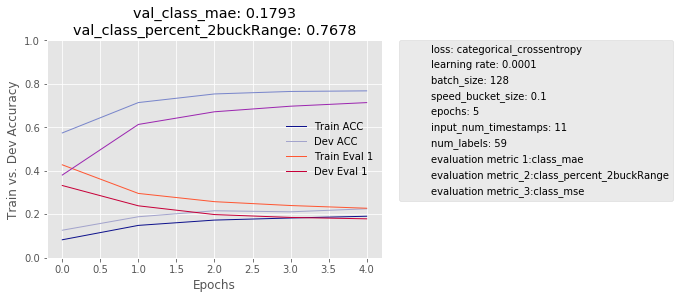

In [23]:
from matplotlib.patches import Rectangle # CHANGED corrected
from matplotlib.legend import Legend

fig, ax1 = plt.subplots()
lines=[]

lines += ax1.plot(trainAccuracy_4,'#0e128c', label='Train Accuracy 2', linewidth=1) #'#DAF7A6'
lines += ax1.plot(devAccuracy_4,'#a3a4cc', label='Dev Accuracy 2', linewidth=1)# '#33FF00',
lines += ax1.plot(trainAccuracy_1,'#FF5733', label='Train Accuracy 1', linewidth=1)
lines += ax1.plot(devAccuracy_1,'#C70039', label='Dev Accuracy 1', linewidth=1)
lines += ax1.plot(trainAccuracy_2,'#9C27B0', label='Train Accuracy 2', linewidth=1)
lines += ax1.plot(devAccuracy_2,'#7986CB', label='Dev Accuracy 2', linewidth=1)
plt.ylim([0.0, 1.0])  # Surpress this for non-classification tasks

plt.ylabel('Train vs. Dev Accuracy')

plt.xlabel('Epochs')
plt.title(dev_reporting_metric_1 + ": " + str(np.around(final_accuracy_dev_1,4)) + "\n" + \
         dev_reporting_metric_2 + ": " + str(np.around(final_accuracy_dev_2,4))) 
extra = Rectangle((0, 0), 1, 1, fc="w", fill=False, edgecolor='none', linewidth=0)
plt.legend([extra,extra,extra,extra,extra,extra,extra,extra,extra,extra],(
                                                "loss: " + loss_function,
                                                "learning rate: " + str(learning_rate),
                                                "batch_size: " + str(batch_size),
                                                "speed_bucket_size: " + speed_bucket_size,
                                                "epochs: "+str(training_epochs),
                                                "input_num_timestamps: " + str(input_num_timestamps),
                                                "num_labels: " + str(len(labels_to_number)),
                                                "evaluation metric 1:"+accuracy_reporting_metric_1,
                                                "evaluation metric_2:"+accuracy_reporting_metric_2,
                                                "evaluation metric_3:"+accuracy_reporting_metric_3, # CHANGED (fixed formatting)
                                                "note:" + plot_note),
                                                bbox_to_anchor=(1.05, 1),
                                                loc=2,
                                                borderaxespad=0.)

leg = Legend(ax1, lines[0:], ['Train ACC', 'Dev ACC','Train Eval 1','Dev Eval 1'], # CHANGED label of dev eval 1
             loc='bestoutside', frameon=False)
ax1.add_artist(leg);
plot_filename=str(time.time())+"User-"+str(socket.gethostname())+plot_note # add plot not to identify this plot
plt.savefig("../plots/"+plot_filename+"_AccuracyVsEpoch.png", bbox_inches = "tight")
plt.show()

#### Record results of a model in a table:

In [ ]:
model_time = end_time-start_time
time_per_epoch = model_time/training_epochs

# Add the results of the most recent run to the results file for documentation
a=[["FCN",
    name,
    "na",
    myFileLocation,
    training_epochs,  
    model_time,
    final_accuracy_1,
    final_accuracy_dev_1,
    final_accuracy_2,
    final_accuracy_dev_2,
    final_accuracy_3,
    final_accuracy_dev_3,
    batch_size,
    num_layers,
    activations_strategy,
    dropout_rates,    
    learning_rate,
    speed_bucket_size,
    loss_function,
    input_num_timestamps,
    label_window_size,
    accuracy_reporting_metric_1,
    accuracy_reporting_metric_2,
    accuracy_reporting_metric_3
    ]]
        
df=pd.DataFrame(a, columns=["model type",
                            "model filename",
                            "plot filename",
                            "data filename",
                            "epochs",
                            "runtime",
                            "train accuracy 1",
                            "dev accuracy 1",
                            "train accuracy 2",
                            "dev accuracy 2",
                            "train accuracy 3",
                            "dev accuracy 3",
                            "batch_size",
                            "num_layers",
                            "activations_strategy",
                            "dropout_rates",    
                            "learning_rate",
                            "speed_bucket_size",
                            "loss_function",
                            "input_num_timestamps",
                            "label_window_size",
                            "evaluation_metric_1",
                            "evaluation_metric_2",
                            "evaluation_metric_3"])

past_results = load_results_file(results_file_name)
past_results=pd.concat([past_results,df])
print(past_results)
past_results.to_csv("../results/"+results_file_name+".csv",index=False ) # FIX TO PUT THE COLUMNS NOT ALPHABETICAL

#### Build Confusion Matrix and Regression Plot

In [ ]:
y_pred = model.predict(X_test)
y_pred_argmax = np.argmax(y_pred, axis=1)

y_true = y_test
y_true_argmax = np.argmax(y_true, axis=1)

In [ ]:
# Plot results
plt.scatter(y_true_argmax, y_pred_argmax, s=3, alpha=0.3)
plt.scatter(y_true_argmax, y_true_argmax, s=3, alpha=1)
#plt.scatter(y_true, y_pred, s=3, alpha=0.3) # For regression
plt.xlim([0,50])
plt.ylim([0,50])
plt.xlabel('Y_True')
plt.ylabel('Y_Prediction')
plt.savefig("../plots/"+name+"_"+plot_filename+"_ConfusionMatrix.png")
plt.show()

# Record data in a an .csv
y_trueVy_pred = np.vstack([y_true_argmax,y_pred_argmax])
df_y_trueVy_pred = pd.DataFrame(np.transpose(y_trueVy_pred))
filepath_predictions = "../results/"+results_file_name+"_Predictions_"+name+".csv"
df_y_trueVy_pred.to_csv(filepath_predictions, header = ["y_true_argmax", "y_pred_argmax"], index=False)

# Create and save a confusion matrix
cm = confusion_matrix(y_true_argmax, y_pred_argmax)
df_cm = pd.DataFrame (cm)
filepath_cm = "../results/"+results_file_name+"ConfusionMatrix.xlsx"
df_cm.to_excel(filepath_cm, index=False)